In [253]:
import numpy as np 
import scipy.io as sci
import matplotlib.pyplot as plt

dataC = sci.loadmat('data/controls.mat')
dataC = dataC['controls']

dataD = sci.loadmat('data/depressed.mat')
dataD = dataD['depressed']

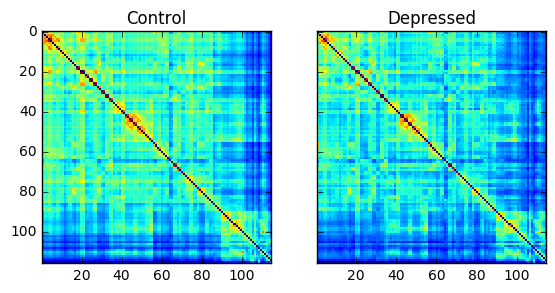

In [254]:
# Let's visualize these first

C_avgd = np.mean(dataC, 0)   #collapse across subjects
D_avgd = np.mean(dataD, 0)

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3), sharey=True)

axs[0].imshow(C_avgd, interpolation='nearest')
axs[0].set_title('Control')
#plt.show()
axs[1].set_title('Depressed')
axs[1].imshow(D_avgd, interpolation='nearest')
plt.show()

# Characteristic Path Length

The *characteristic path length* is the average of the shortest distances between all vertices. We'll take all pairs of vertices, calculate the shortest distance, then average the collection that we obtain. Since correlation is an undirected connectivity measure (i.e. *Corr(x, y) = Corr(y, x)*), we can cut the number of distances we have to calculate by half. 

A network with a low CPL (usually) has a nice situation going with information transfer (distance is minimized between nodes). For correlation values, we'll have to take absolute values in order to make sure we're measuring a true "distance". So our pipeline looks like:

Correlation Matrices → Absolute Correlation → Distance Matrices → Characteristic Path Length

Food for thought: Can an excessively low CPL be bad? In a brain, what anatomical and information-theoretic considerations might counterbalance the benefits of low CPL? 

In [255]:
# Calculate characteristic path length

import scipy.sparse.csgraph as graphs

CPL_C = np.zeros(dataC.shape[0])
CPL_D = np.zeros(dataD.shape[0])

for subj in range(0, dataC.shape[0]):
    dist = graphs.shortest_path(np.abs(dataC[subj,:,:]), method = 'D')  #our connectivity measure can be negative
    CPL_C[subj] = np.nanmean(np.nanmean(np.where(dist!=0, dist, np.nan),1))
    
for subj in range(0, dataD.shape[0]):
    dist = graphs.shortest_path(np.abs(dataD[subj,:,:]), method = 'D')  
    CPL_D[subj] = np.nanmean(np.nanmean(np.where(dist!=0, dist, np.nan),1))


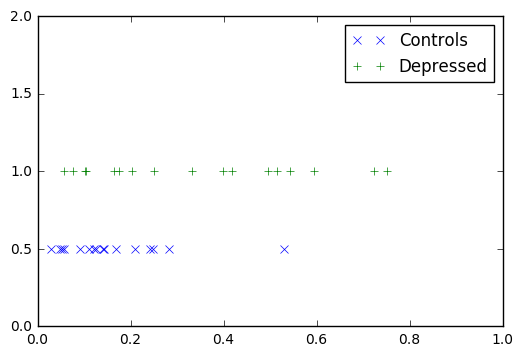

In [256]:
# Visualize our CPL measures between groups

plt.plot(CPL_D, len(CPL_D) * [0.5], "x", label = 'Controls')
plt.plot(CPL_C, len(CPL_C) * [1], "+", label = 'Depressed')
plt.axis([0, 1,0,2])
plt.legend()
plt.show()

# We'll test the group difference significance later...

# Connected Components

Sometimes we may want to understand how many components the network can cleanly separate into (Ashton will cover the a quantification of "cleanly" later). In order to do this with our current data, we'll have to *threshold* our matrix by setting equal to 0 any values below a given threshold.

Some things to note about this process:
   * We assume functional connections weaker than our threshold are noise. 
   * Thresholding can make the data easier to work with or visualize.
   * Many analyses have pointed out that network structure can vary significantly under different thresholds.


Food for thought: What might be a principled way to choose a threshold? What network measures are robust to thresholding?

In [257]:
# Connected Components: Thresholding

bin_C = np.ones(dataC.shape)   # we'll have to store our adjacency matrices following binarization
bin_D = np.ones(dataD.shape)

thresh = 1.4                # our threshold; all values < epsilon will be assigned a 0
                             # abs(values) range from 0 to 2.9; mess with epsilon accordingly 

sub_threshold_indices = np.abs(dataC) < thresh
bin_C[sub_threshold_indices] = 0  

sub_threshold_indices = np.abs(dataD) < thresh
bin_D[sub_threshold_indices] = 0    




Now that we've thresholded our matrix, we can proceed with two approaches for computing connected components: the *depth-first search* algorithm and the *Laplacian*. The former is far more numerically stable and has a lower runtime but, for ~culture~, we'll also discuss the Laplacian. 

**Depth First Search**

Pick a node. We'll branch out from it by exploring all connected nodes (the "depth" in the name is because, as soon as we hit a new node, we'll explore down that avenue instead - visualizing this, we're exploring deep down a branch as opposed to checking all neighboring nodes first). We'll explore all connected nodes and note when we've visited a node. 

Now pick another node. If it's been visited, we move on. If not, we add +1 to our connected component count and then perform the above procedure. 

**Laplacian**

Refresher/dirty explanation: the *kernel* of a matrix is the set of all vectors x such that Ax = 0. The *dimension* is the minimal number of vectors required to represent all other vectors in the kernel through simple, linear combinations. 

Let *A* be the adjacency matrix (recall earlier slides). Let *D* be the diagonal degree matrix, where D<sub>i,i</sub> is the degree of the vertex *i*.

The Laplacian matrix is defined as *L := D - A* and has a number of remarkable properties. For our interests, the size of the kernel yields the number of connected components. This procedure of studying a graph by using techniques from linear algebra on associated matrices is a fun/painful area called spectral graph theory. 

Ignoring abstract nonsense, we can find the dimension of the kernel using some fancy linear algebra. Let's compute connected components using both approaches and see if they differ. Then we'll follow up and graph both populations for comparison. 





In [258]:
# Connected Components: Computation 

comp_C = np.zeros([dataC.shape[0], 2])  #column 1: DFS result; column 2: Laplacian result 
comp_D = np.zeros([dataD.shape[0], 2])

eps = 1e-7                              #numerical stability stuff 

for subj in range(0, dataC.shape[0]):
    comp_C[subj,0] = graphs.connected_components(bin_C[subj,:,:])[0]   #DFS
    
    lap       = graphs.laplacian(bin_C[subj,:,:])                      #Create Laplacian
    u, s, vh  = np.linalg.svd(lap)                                     #under the hood: find nullspace
    null_mask = (s <= eps)
    null_space     = np.compress(null_mask, vh, axis=0)
    comp_C[subj,1] = null_space.shape[0]
    
    
for subj in range(0, dataD.shape[0]):
    comp_D[subj,0] = graphs.connected_components(bin_D[subj,:,:])[0]
    
    lap = graphs.laplacian(bin_D[subj,:,:])
    u, s, vh  = np.linalg.svd(lap)
    null_mask = (s <= eps)
    null_space     = np.compress(null_mask, vh, axis=0)
    comp_D[subj,1] = null_space.shape[0]


Sum of method differences for controls is: 0.0
Sum of method differences for depressed is: 0.0


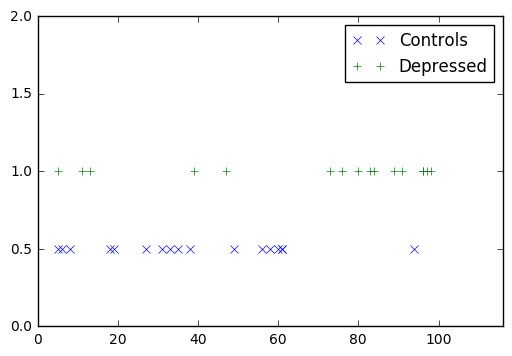

In [259]:
# Let's check out our results

#all values positive --> if 0 then both methods agree 100%
print('Sum of method differences for controls is:', np.mean(np.abs(comp_D[:,0] - comp_D[:,1]))) 
print('Sum of method differences for depressed is:', np.mean(np.abs(comp_C[:,0] - comp_C[:,1])))

# now plot group differences
plt.plot(comp_C[:,0], len(comp_C[:,0]) * [0.5], "x", label = 'Controls')
plt.plot(comp_D[:,0], len(comp_D[:,0]) * [1], "+", label = 'Depressed')
plt.axis([0, 116,0,2])
plt.legend()
plt.show()


In [260]:
# Robust against threshold choice? Generate 100 thresholds, look at avg connected component number for each

bin_C = np.ones(dataC.shape)   
bin_D = np.ones(dataD.shape)

ind_comp_C = np.zeros([dataC.shape[0], 2])
ind_comp_D = np.zeros([dataC.shape[0], 2])   
avg_comp   = np.zeros([100, 2])            # column 1: controls; Column 2: depressed

thresh = 0.025                             # initial threshold; we'll move it in increments

for i in range(0, 100): 
    sub_threshold_indices_C = np.abs(dataC) < (thresh * i)  
    sub_threshold_indices_D = np.abs(dataD) < (thresh * i)
    bin_C[sub_threshold_indices_C] = 0  
    bin_D[sub_threshold_indices_D] = 0 
    
    for subj in range(0, dataC.shape[0]):
        ind_comp_C[subj,0] = graphs.connected_components(bin_C[subj,:,:])[0] 
    for subj in range(0, dataD.shape[0]):
        ind_comp_D[subj,1] = graphs.connected_components(bin_D[subj,:,:])[0] 
    avg_comp[i,:] = [np.mean(ind_comp_C), np.mean(ind_comp_D)]
      

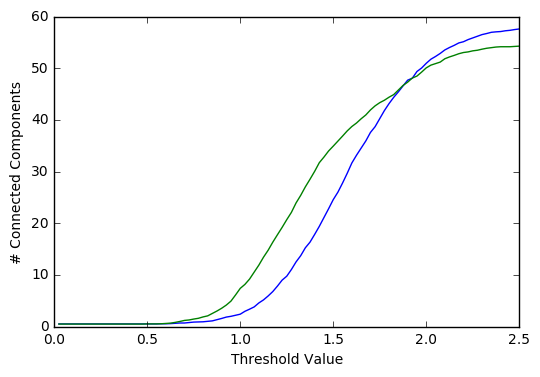

In [261]:
plt.plot(np.linspace(0.025, 2.5, 100), avg_comp[:,0])
plt.plot(np.linspace(0.025, 2.5, 100), avg_comp[:,1])
plt.ylabel('# Connected Components')
plt.xlabel('Threshold Value')
plt.show()

As we can see, the number of connected components varies dramatically as a function of our threshold. This often makes analyses based off of thresholding A) harder to replicate and B) more prone to somehow getting nice results (:thinking emoji:) by introducing more degrees of freedom into experimental design.

Thankfully, there are a couple approaches that can be taken to mitigate the issue here:
   * Introduce standards.
   * Consider how the graph structure changes as a function of the threshold. Examine graph properties at *all* possible thresholds and study the persistence of various structures as we change our "lens". This approach is called persistent homology and is another cool/painful area for those interested.
   * Use another metric (Ashton, you're up).
  